# **Personal Finance Optimizer**
A comprehensive linear and quadratic optimization system that automates personal financial planning and investment allocation to maximize long-term wealth accumulation.

**Installing Dependencies**

This section imports all necessary libraries and sets up the environment for financial data analysis, optimization, and visualization.

 Key Components:
 - pulp: Linear programming for budget optimization
 - cvxpy: Quadratic programming for portfolio optimization  
 - yfinance: Financial data download from Yahoo Finance
 - pandas/numpy: Data manipulation and numerical computations
 - matplotlib/seaborn: Data visualization and plotting

In [1]:
!pip install pulp cvxpy yfinance pandas numpy matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 55.6 MB/s eta 0:00:00


**Importing The Necessary Libraries**

In [2]:
# Importing all necessary libraries
import pulp
import cvxpy as cp
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up a unique style for our plots using Seaborn
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

## **💰 Step 1: The Cash Flow Optimizer**

**1.1. Define the Problem and Data**

In [3]:
# Decision Variables: Amount to spend in each category (Rent, Food, Transport, Utilities, Healthcare, Leisure, Savings)

# Constraints:
# - Total spending cannot exceed income
# - Minimum living standards must be met
# - Maximum comfortable spending limits

# Monthly Income
monthly_income = 5000  # Dollars

# Creating a list of spending categories
categories = ['Rent', 'Food', 'Transport', 'Utilities', 'Healthcare', 'Leisure', 'Savings']

# Creating a dictionary for minimum required spending for each category.
min_spending = {
    'Rent': 1200,
    'Food': 400,
    'Transport': 300,
    'Utilities': 150,
    'Healthcare': 100,
    'Leisure': 0,  # This can be set to 0, meaning it can be cut completely to save more money.
    'Savings': 0   # Since we want to maximize savings, we set the minimum number for saving to 0.
}

# Creating a dictionary for maximum allowed spending.
# Ideally, we don't want to spend more than this, even if we have the funds.
max_spending = {
    'Rent': 1500,
    'Food': 600,
    'Transport': 400,
    'Utilities': 200,
    'Healthcare': 200,
    'Leisure': 800,
    'Savings': monthly_income  # Can't save more than you earn!
}

# Creating the LP problem object. Our goal is to maximize savings.
prob_budget = pulp.LpProblem("Monthly_Budget_Optimization", pulp.LpMaximize)

**1.2. Create Decision Variables**

In [4]:
# Creating decision variables for each category.
# First, we create them with very wide bounds (e.g., 0 to infinity).
spend_vars = pulp.LpVariable.dicts("Spend", categories, lowBound=0, cat='Continuous')

# Secondly, we add the min and max spending as constraints to the problem
for cat in categories:
    # Adding minimum spending constraint: Spend[cat] >= min_spending[cat]
    prob_budget += spend_vars[cat] >= min_spending[cat], f"Min_{cat}"

    # Adding maximum spending constraint: Spend[cat] <= max_spending[cat]
    prob_budget += spend_vars[cat] <= max_spending[cat], f"Max_{cat}"

**1.3. Define the Objective Function and Constraints**

In [5]:
# Objective Function: Maximize Savings (which is just one of our variables)
prob_budget += spend_vars['Savings'], "Total_Savings"

# The Main Constraint: Total Spending + Savings must equal Income
prob_budget += pulp.lpSum([spend_vars[cat] for cat in categories]) == monthly_income, "Total_Income_Constraint"

# Other constraints can be added

**1.4. Solve the Model and View Results**

In [6]:
# Solving the problem
prob_budget.solve()

# Checking the solution status
print("Status:", pulp.LpStatus[prob_budget.status])
print("="*50)

# Printing the optimal spending plan
if prob_budget.status == pulp.LpStatusOptimal:
    print("OPTIMAL MONTHLY SPENDING PLAN:")
    print(f"Income: ${monthly_income}")
    print("-" * 30)
    total_spend = 0
    for category in categories:
        value = spend_vars[category].varValue
        print(f"{category}: ${value: .2f}")
        if category != 'Savings':
            total_spend += value
    print("-" * 30)
    print(f"Total Spending: ${total_spend: .2f}")
    print(f"Total Savings: ${spend_vars['Savings'].varValue: .2f}")
else:
    print("The model could not find an optimal solution. Check your constraints.")

Status: Optimal
OPTIMAL MONTHLY SPENDING PLAN:
Income: $5000
------------------------------
Rent: $ 1200.00
Food: $ 400.00
Transport: $ 300.00
Utilities: $ 150.00
Healthcare: $ 100.00
Leisure: $ 0.00
Savings: $ 2850.00
------------------------------
Total Spending: $ 2150.00
Total Savings: $ 2850.00


## **📈 Step 2: The Portfolio Optimizer**

**2.1. Get Historical Data and Calculate Metrics**

In [7]:
# Defining the assets we want to invest in (using ETF tickers)
tickers = ['SPY', 'QQQ', 'VXUS', 'AGG', 'BTC-USD'] # US Stocks, Tech Stocks, Int'l Stocks, Bonds, Bitcoin

# Creating an empty DataFrame for closing prices
closing_prices = pd.DataFrame()

# Downloading each ticker separately and combine
for ticker in tickers:
    print(f"Downloading {ticker}...")
    try:
        # Downloading with auto_adjust=True (now the default)
        ticker_data = yf.download(ticker, start="2018-01-01", end="2023-12-31", progress=False)

        # When auto_adjust=True, we use 'Close' instead of 'Adj Close'
        # The closing prices are already adjusted for splits and dividends
        closing_prices[ticker] = ticker_data['Close']
        print(f"Successfully downloaded {ticker} with {len(ticker_data)} data points")

    except Exception as e:
        print(f"Error downloading {ticker}: {e}")

print(f"\nFinal data shape: {closing_prices.shape}")
print("\nFirst few rows of data:")
print(closing_prices.head())

print("\nData info:")
print(closing_prices.info())

# Checking for any missing values
print(f"\nMissing values per ticker:")
print(closing_prices.isnull().sum())

# Handling missing values if any (forward fill then drop any remaining NaN)
if closing_prices.isnull().sum().sum() > 0:
    print("Handling missing values...")
    closing_prices = closing_prices.ffill().dropna()

# Calculating daily returns
returns = closing_prices.pct_change().dropna()
print(f"\nReturns data shape: {returns.shape}")

# Calculating annual returns and covariance matrix
annual_returns = returns.mean() * 252  # Trading days in a year
cov_matrix = returns.cov() * 252       # Annualized covariance matrix

print("\nExpected Annual Returns:")
print(annual_returns)
print("\nAnnual Covariance Matrix:")
print(cov_matrix)

# Verifing the data looks reasonable
print(f"\nSample statistics:")
print(f"Date range: {closing_prices.index[0]} to {closing_prices.index[-1]}")
print(f"Number of trading days: {len(closing_prices)}")

/tmp/ipython-input-3941742701.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ticker_data = yf.download(ticker, start="2018-01-01", end="2023-12-31", progress=False)


Successfully downloaded SPY with 1509 data points


/tmp/ipython-input-3941742701.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ticker_data = yf.download(ticker, start="2018-01-01", end="2023-12-31", progress=False)


Successfully downloaded QQQ with 1509 data points


/tmp/ipython-input-3941742701.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ticker_data = yf.download(ticker, start="2018-01-01", end="2023-12-31", progress=False)


Successfully downloaded VXUS with 1509 data points


/tmp/ipython-input-3941742701.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ticker_data = yf.download(ticker, start="2018-01-01", end="2023-12-31", progress=False)


Successfully downloaded AGG with 1509 data points


/tmp/ipython-input-3941742701.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ticker_data = yf.download(ticker, start="2018-01-01", end="2023-12-31", progress=False)


Successfully downloaded BTC-USD with 2190 data points

Final data shape: (1509, 5)

First few rows of data:
                   SPY         QQQ       VXUS        AGG       BTC-USD
Date                                                                  
2018-01-02  238.568756  150.779907  45.895725  88.417137  14982.099609
2018-01-03  240.077744  152.245071  46.215672  88.425270  15201.000000
2018-01-04  241.089630  152.511398  46.599621  88.368546  15599.200195
2018-01-05  242.696259  154.043076  46.911549  88.311852  17429.500000
2018-01-08  243.140060  154.642471  46.887558  88.287537  15170.099609

Data info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1509 entries, 2018-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SPY      1509 non-null   float64
 1   QQQ      1509 non-null   float64
 2   VXUS     1509 non-null   float64
 3   AGG      1509 non-null   float64
 4   BTC-USD  1509 non-null   f


Data Quality Check
Last 5 rows of data:
                   SPY         QQQ       VXUS        AGG       BTC-USD
Date                                                                  
2023-12-22  464.874390  404.695343  54.842690  93.097153  43997.902344
2023-12-26  466.837372  407.172821  55.110870  93.285545  42520.402344
2023-12-27  467.681458  408.001709  55.446098  93.878990  43442.855469
2023-12-28  467.858093  407.803406  55.474823  93.671761  42627.855469
2023-12-29  466.503662  406.038513  55.513134  93.492790  42099.402344

Return statistics:
               SPY          QQQ         VXUS          AGG      BTC-USD
count  1508.000000  1508.000000  1508.000000  1508.000000  1508.000000
mean      0.000528     0.000782     0.000197     0.000044     0.001649
std       0.012844     0.015750     0.011883     0.003820     0.043515
min      -0.109424    -0.119788    -0.111318    -0.040011    -0.371695
25%      -0.004947    -0.006567    -0.005455    -0.001578    -0.016641
50%       0.0007

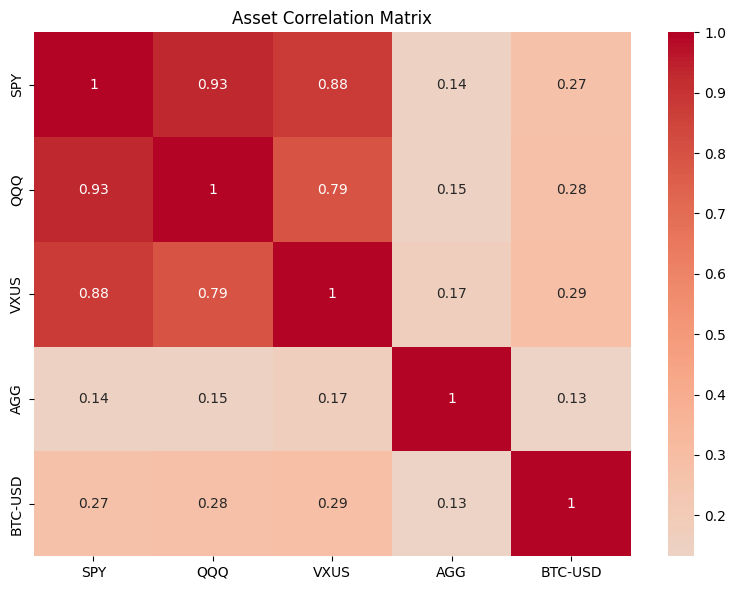

In [13]:
# Quick check for data quality after alignment
print("\n" + "="*50)
print("Data Quality Check")
print("="*50)

# Checking the last few rows to see if we have recent data
print("Last 5 rows of data:")
print(closing_prices.tail())

# Checking if returns look reasonable (no extreme outliers)
print(f"\nReturn statistics:")
print(returns.describe())

# Checking correlation matrix (should match our intuition)
print(f"\nCorrelation Matrix:")
correlation_matrix = returns.corr()
print(correlation_matrix)

# Quick visualization of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Asset Correlation Matrix')
plt.tight_layout()
plt.show()

**2.2. Define and Solve the Portfolio Optimization Problem**

We'll use Markowitz Portfolio Theory. We'll maximize return for a given risk level.

In [9]:
# Number of assets
n_assets = len(tickers)

# The decision variables: weights for each asset (must sum to 1)
weights = cp.Variable(n_assets)

# Define the expected portfolio return and risk (variance)
portfolio_return = annual_returns.values @ weights
portfolio_risk = cp.quad_form(weights, cov_matrix.values)

# Define risk tolerance (this is your personal choice - play with this value!)
# Higher gamma means more risk averse (prioritizes minimizing risk).
# Lower gamma means more risk seeking (prioritizes maximizing return).
gamma = cp.Parameter(nonneg=True)
gamma.value = 0.5  # This is a good starting point. Try 0.1, 0.5, 1, 5, 10.

# Define the problem: Maximize (Return - Risk * RiskAversion)
objective = cp.Maximize(portfolio_return - gamma * portfolio_risk)
constraints = [cp.sum(weights) == 1, weights >= 0] # Fully invested, no shorting
prob_portfolio = cp.Problem(objective, constraints)

# Solving the problem
prob_portfolio.solve()

# Getting the optimal weights
optimal_weights = weights.value

print("Status:", prob_portfolio.status)
print("Optimal Portfolio Allocation:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight: .2%}")
print(f"Expected Annual Return: {portfolio_return.value: .2%}")
print(f"Expected Annual Risk (Std Dev): {np.sqrt(portfolio_risk.value): .2%}")

Status: optimal
Optimal Portfolio Allocation:
SPY:  0.00%
QQQ:  47.47%
VXUS:  0.00%
AGG:  0.00%
BTC-USD:  52.53%
Expected Annual Return:  31.18%
Expected Annual Risk (Std Dev):  41.19%


## **🎯 Step 3: The Multi-Year Projection**

This is where we combine both models into a powerful simulation.

In [10]:
n_years = 20
initial_savings = 1000  # Starting savings

# Initializing dictionaries to track our progress over time
projection_df = pd.DataFrame(index=range(n_years+1),
                             columns=['Year', 'Net_Income', 'Expenses', 'New_Savings',
                                      'Portfolio_Value', 'Return', 'Total_Net_Worth'])
projection_df['Year'] = range(n_years+1)
projection_df.loc[0, 'Portfolio_Value'] = initial_savings
projection_df.loc[0, 'Total_Net_Worth'] = initial_savings

# Assume a 3% annual salary raise
salary_growth_rate = 0.03
current_income = monthly_income * 12  # Annual income

for year in range(1, n_years+1):
    print(f"Simulating year {year}...")

    # 1. Updating income for the year (with a raise)
    current_income *= (1 + salary_growth_rate)
    monthly_income_yr = current_income / 12
    projection_df.loc[year, 'Net_Income'] = current_income

    # 2. Updating the budget model's income constraint and solving it
    prob_budget.constraints["Total_Income_Constraint"] = pulp.lpSum([spend_vars[cat] for cat in categories]) == monthly_income_yr
    prob_budget.solve()

    # 3. Calculating annual savings from the budget model
    annual_savings = spend_vars['Savings'].varValue * 12
    projection_df.loc[year, 'New_Savings'] = annual_savings
    projection_df.loc[year, 'Expenses'] = current_income - annual_savings

    # 4. Getting the previous year's portfolio value
    previous_portfolio_value = projection_df.loc[year-1, 'Portfolio_Value']

    # 5. Adding new savings to the portfolio principal
    total_principal = previous_portfolio_value + annual_savings

    # 6. Solving the portfolio model to get this year's expected return
    # (We use the same optimal weights we calculated above)
    expected_portfolio_return = np.dot(optimal_weights, annual_returns.values)

    # 7. Projecting the new portfolio value (using the expected return)
    new_portfolio_value = total_principal * (1 + expected_portfolio_return)
    projection_df.loc[year, 'Return'] = expected_portfolio_return
    projection_df.loc[year, 'Portfolio_Value'] = new_portfolio_value
    projection_df.loc[year, 'Total_Net_Worth'] = new_portfolio_value  # Assuming no other assets

# Filling any NaN values with 0 for plotting
projection_df.fillna(0, inplace=True)
print("Projection complete!")

Simulating year 1...
Simulating year 2...
Simulating year 3...
Simulating year 4...
Simulating year 5...
Simulating year 6...
Simulating year 7...
Simulating year 8...
Simulating year 9...
Simulating year 10...
Simulating year 11...
Simulating year 12...
Simulating year 13...
Simulating year 14...
Simulating year 15...
Simulating year 16...
Simulating year 17...
Simulating year 18...
Simulating year 19...
Simulating year 20...
Projection complete!


/tmp/ipython-input-1959851382.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  projection_df.fillna(0, inplace=True)


## **📊 Step 4: Visualization**

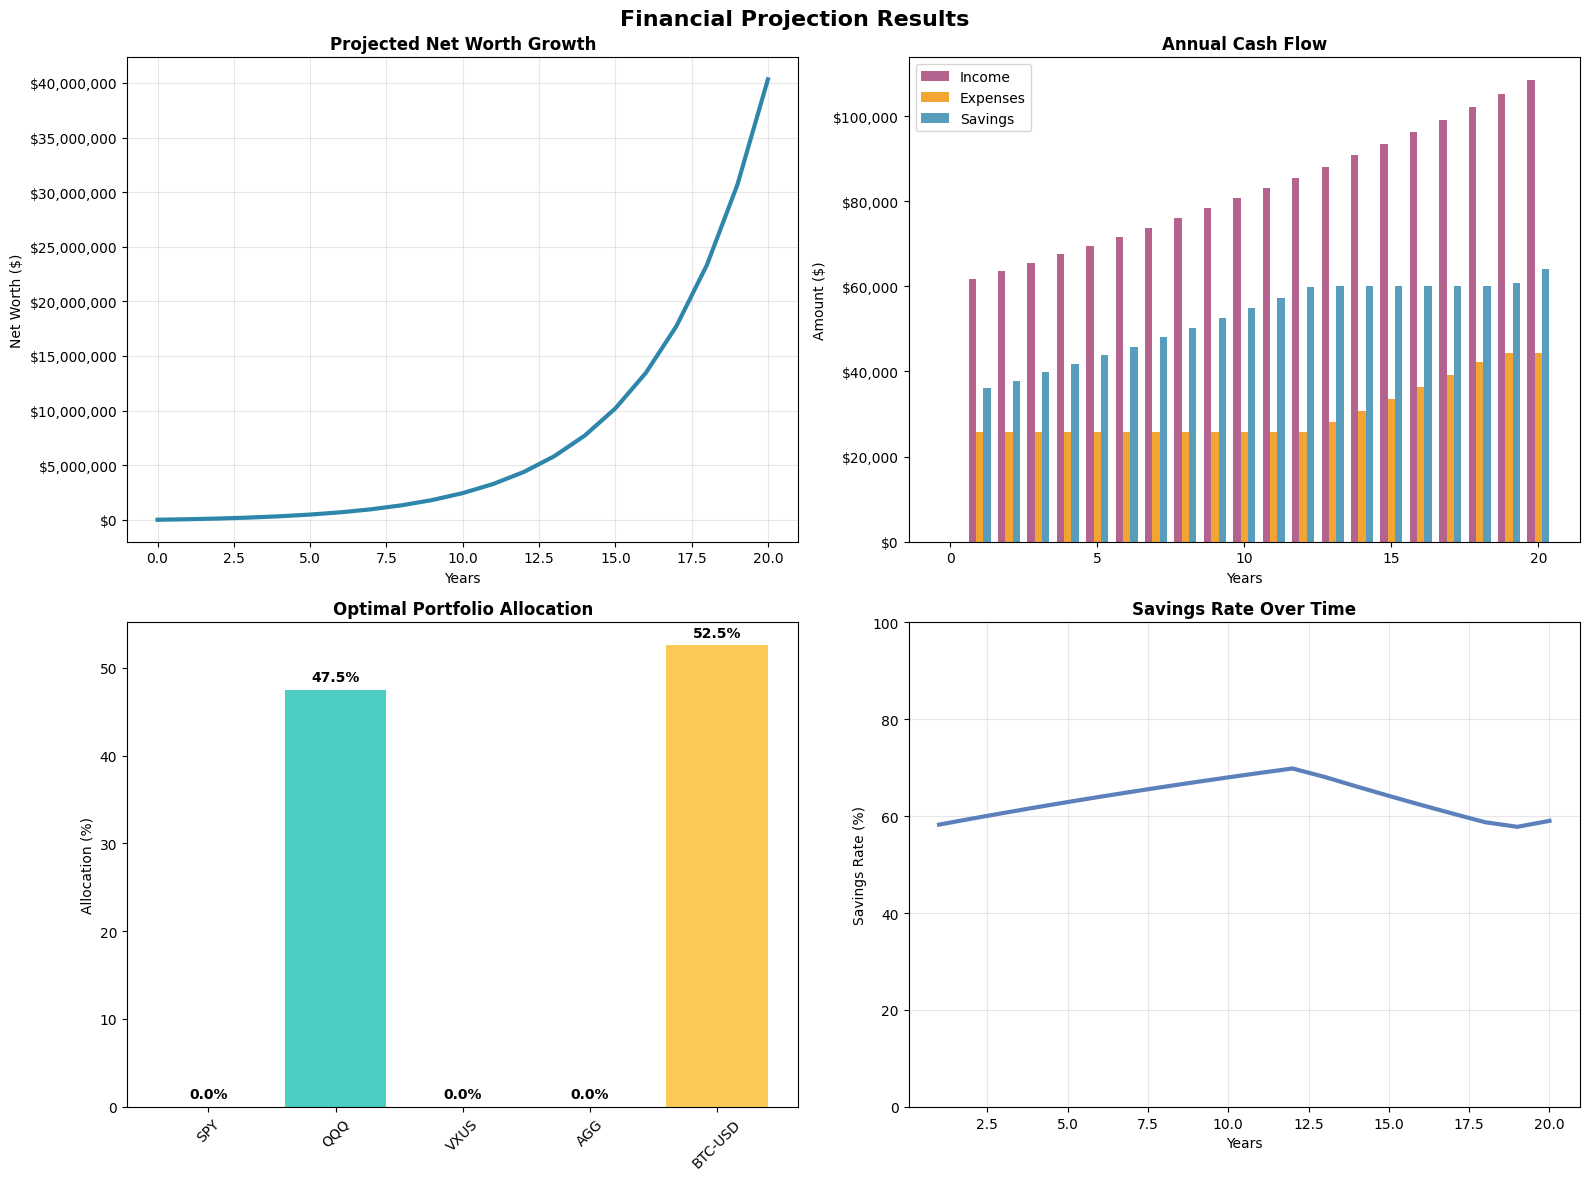

Summary
Projection Period: 20 years
Initial Net Worth: $1,000
Final Net Worth: $40,333,737
Growth Multiple: 40,333.7x
Final Annual Income: $108,367
Average Savings Rate: 63.4%
Expected Portfolio Return: 31.18% annually

Key Metrics
Year 1 Savings: $36,000
Year 20 Savings: $63,967
Year 1 Net Worth: $48,536
Year 20 Net Worth: $40,333,737


In [14]:
# Setting up the plotting style
plt.style.use('default')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Financial Projection Results', fontsize=16, fontweight='bold')

# Plot 1: Net Worth Growth
ax1.plot(projection_df['Year'], projection_df['Total_Net_Worth'], linewidth=3, color='#2E86AB')
ax1.set_title('Projected Net Worth Growth', fontweight='bold')
ax1.set_xlabel('Years')
ax1.set_ylabel('Net Worth ($)')
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))

# Plot 2: Income vs Expenses vs Savings
years = projection_df['Year']
width = 0.25
ax2.bar(years - width, projection_df['Net_Income'], width, label='Income', alpha=0.8, color='#A23B72')
ax2.bar(years, projection_df['Expenses'], width, label='Expenses', alpha=0.8, color='#F18F01')
ax2.bar(years + width, projection_df['New_Savings'], width, label='Savings', alpha=0.8, color='#2E86AB')
ax2.set_title('Annual Cash Flow', fontweight='bold')
ax2.set_xlabel('Years')
ax2.set_ylabel('Amount ($)')
ax2.legend()
ax2.yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))

# Plot 3: Portfolio Allocation (as a bar chart for clarity)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']
ax3.bar(tickers, optimal_weights * 100, color=colors)
ax3.set_title('Optimal Portfolio Allocation', fontweight='bold')
ax3.set_ylabel('Allocation (%)')
ax3.tick_params(axis='x', rotation=45)
for i, v in enumerate(optimal_weights * 100):
    ax3.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# Plot 4: Savings Rate
savings_rate = (projection_df['New_Savings'] / projection_df['Net_Income']) * 100
ax4.plot(projection_df['Year'], savings_rate, linewidth=3, color='#5C80BC')
ax4.set_title('Savings Rate Over Time', fontweight='bold')
ax4.set_xlabel('Years')
ax4.set_ylabel('Savings Rate (%)')
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0, 100)  # Savings rate can't exceed 100%

plt.tight_layout()
plt.show()

# Print final summary
final_net_worth = projection_df['Total_Net_Worth'].iloc[-1]
final_income = projection_df['Net_Income'].iloc[-1]
avg_savings_rate = savings_rate.mean()

print("=" * 60)
print("Summary")
print("=" * 60)
print(f"Projection Period: {n_years} years")
print(f"Initial Net Worth: ${initial_savings:,.0f}")
print(f"Final Net Worth: ${final_net_worth:,.0f}")
print(f"Growth Multiple: {final_net_worth/initial_savings:,.1f}x")
print(f"Final Annual Income: ${final_income:,.0f}")
print(f"Average Savings Rate: {avg_savings_rate:.1f}%")
print(f"Expected Portfolio Return: {projection_df['Return'].iloc[-1]:.2%} annually")

# Show some key metrics
print("\n" + "=" * 40)
print("Key Metrics")
print("=" * 40)
print(f"Year 1 Savings: ${projection_df['New_Savings'].iloc[1]:,.0f}")
print(f"Year 20 Savings: ${projection_df['New_Savings'].iloc[-1]:,.0f}")
print(f"Year 1 Net Worth: ${projection_df['Total_Net_Worth'].iloc[1]:,.0f}")
print(f"Year 20 Net Worth: ${projection_df['Total_Net_Worth'].iloc[-1]:,.0f}")